In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer


nltk.download('/content/twitter_training.csv')

[nltk_data] Error loading /content/twitter_training.csv: Package
[nltk_data]     '/content/twitter_training.csv' not found in index


False

In [2]:

df=pd.read_csv(r'/content/twitter_training.csv')


df.head()

,2401,Borderlands,Positive,"im getting on borderlands and i will murder you all ,"
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...


In [3]:

df.drop(df.columns[0], axis=1, inplace=True)
df.head()

,Borderlands,Positive,"im getting on borderlands and i will murder you all ,"
0,Borderlands,Positive,I am coming to the borders and I will kill you...
1,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,Borderlands,Positive,im coming on borderlands and i will murder you...
3,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,Borderlands,Positive,im getting into borderlands and i can murder y...


In [4]:
df.columns = ["media","sentiment", "response"]
df.head()

,media,sentiment,response
0,Borderlands,Positive,I am coming to the borders and I will kill you...
1,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,Borderlands,Positive,im coming on borderlands and i will murder you...
3,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,Borderlands,Positive,im getting into borderlands and i can murder y...


In [5]:
df.columns

Index(['media', 'sentiment', 'response'], dtype='object')

In [6]:
df.describe(include='all')

,media,sentiment,response
count,74681,74681,73995
unique,32,4,69490
top,TomClancysRainbowSix,Negative,
freq,2400,22542,172


In [7]:
df.shape

(74681, 3)

In [8]:
df=df[df['sentiment']!='Neutral']
df=df[df['sentiment']!='Irrelevant']


df = df.groupby(['media','sentiment','response']).size().reset_index(name='count')


df.shape

(41113, 4)

In [9]:
senti=df.sentiment.factorize()


df.head()

,media,sentiment,response,count
0,Amazon,Negative,"""Amazon is a big abomination to a business tha...",1
1,Amazon,Negative,"""Amazon is a big eater of a company that has h...",1
2,Amazon,Negative,"""One of the Saddest Days of My Life"": The Chie...",1
3,Amazon,Negative,"""One of the saddest days of my life"": Queens b...",1
4,Amazon,Negative,"""What are your side projects?."" ""Open source m...",1


In [10]:
print(df['sentiment'].unique())


['Negative' 'Positive']


In [11]:

from tensorflow.keras.preprocessing.text import Tokenizer


# prompt: tweet = review_df.text.values

tweet = df.response.values



tok=Tokenizer(num_words=5000)
tok.fit_on_texts(tweet)


enco=tok.texts_to_sequences(tweet)


from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense, Dropout, SpatialDropout1D
from tensorflow.keras.layers import Embedding


embedding_vector_length = 32
model = Sequential()
model.add(Embedding(len(tok.word_index) + 1, embedding_vector_length, input_length=100))
model.add(SpatialDropout1D(0.25))
model.add(LSTM(50, dropout=0.5, recurrent_dropout=0.5))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])


print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 32)           662624    
                                                                 
 spatial_dropout1d (Spatial  (None, 100, 32)           0         
 Dropout1D)                                                      
                                                                 
 lstm (LSTM)                 (None, 50)                16600     
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 679275 (2.59 MB)
Trainable params: 679275 (2.59 MB)
Non-trainable params: 0 (0.00 Byte)
____________________

In [14]:
padded_sequence = pad_sequences(enco,maxlen=100)
sentiment_label = senti[0]
history = model.fit(padded_sequence,sentiment_label,validation_split=0.2, epochs=5, batch_size=32)


Epoch 1/5
1028/1028 [==============================] - 165s 156ms/step - loss: 0.4460 - accuracy: 0.7863 - val_loss: 0.4778 - val_accuracy: 0.7924
Epoch 2/5
1028/1028 [==============================] - 156s 152ms/step - loss: 0.2928 - accuracy: 0.8754 - val_loss: 0.5735 - val_accuracy: 0.7846
Epoch 3/5
1028/1028 [==============================] - 157s 152ms/step - loss: 0.2457 - accuracy: 0.8951 - val_loss: 0.6098 - val_accuracy: 0.7758
Epoch 4/5
1028/1028 [==============================] - 157s 153ms/step - loss: 0.2178 - accuracy: 0.9091 - val_loss: 0.7597 - val_accuracy: 0.7788
Epoch 5/5
1028/1028 [==============================] - 152s 148ms/step - loss: 0.1962 - accuracy: 0.9151 - val_loss: 0.7521 - val_accuracy: 0.7775


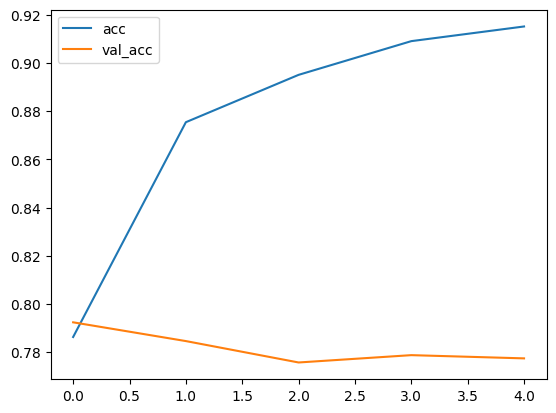

<Figure size 640x480 with 0 Axes>

In [15]:
plt.plot(history.history['accuracy'], label='acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()
plt.savefig("Accuracy plot.jpg")

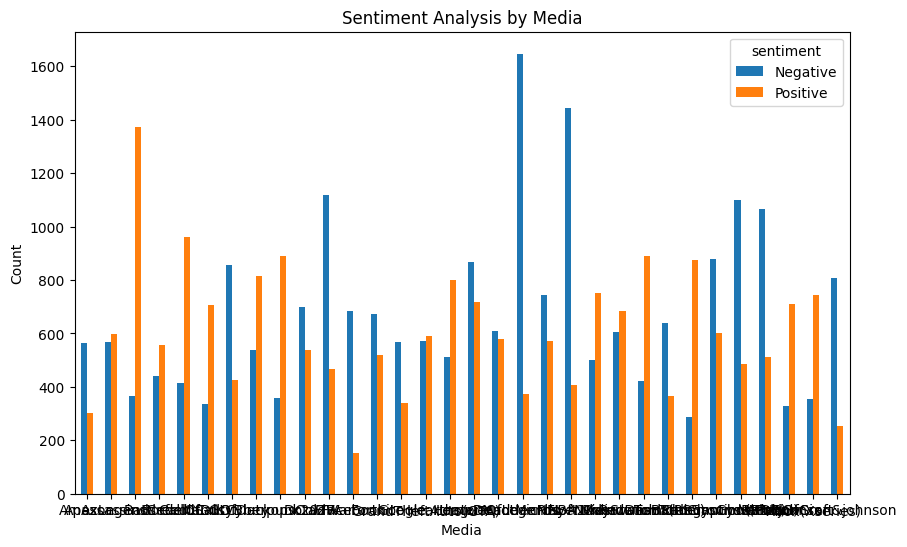

In [16]:
df_patterns = df.groupby(['media','sentiment']).size().reset_index(name='count')
df_patterns = df_patterns.pivot(index='media', columns='sentiment', values='count')
ax = df_patterns.plot(kind='bar', figsize=(10, 6), rot=0)
plt.title("Sentiment Analysis by Media")
plt.xlabel("Media")
plt.ylabel("Count")
plt.show()

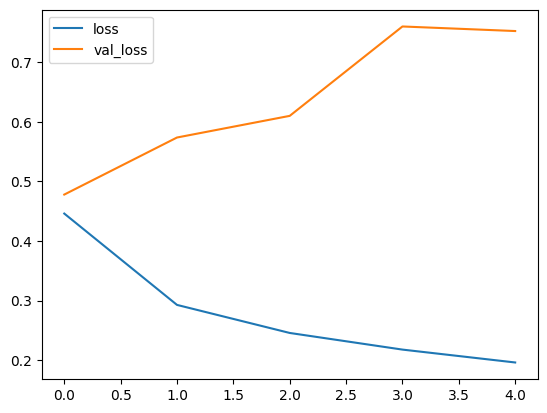

<Figure size 640x480 with 0 Axes>

In [17]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()
plt.savefig("Loss plt.jpg")